In [14]:
import results
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", rc = {
   "legend.frameon": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": "Helvetica",
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.labelsize": 16,
    'legend.fontsize': 12
})


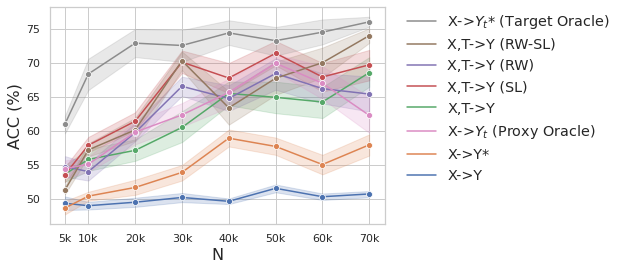

In [15]:
df, meandf  = results.get_erm_convergence_result_df('erm_convergence_rates_no_crossfit_beta3_alpha1_R15')
df['ACC']= df['ACC']*100
df.reset_index(inplace=True)

fig = sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')
fig.set_xlabel('N')
fig.set_ylabel('ACC (%)')

handles, labels = plt.gca().get_legend_handles_labels()

disp_names = {
    'Target Oracle': 'X->$Y_t$* (Target Oracle)',
    'RW-SL': 'X,T->Y (RW-SL)',
    'COM-SL': 'X,T->Y (SL)',
    'COM': 'X,T->Y',
    'RW': 'X,T->Y (RW)',
    'Proxy Oracle': 'X->$Y_t$ (Proxy Oracle)',
    'OBS Oracle': 'X->Y*',
    'OBS': 'X->Y'
}
order = [7,5,4,3,2,6,1,0]
plt.legend([handles[idx] for idx in order],[disp_names[labels[idx]] for idx in order],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

fig.set_xticks([5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000], labels=['5k', '10k', '20k', '30k', '40k', '50k', '60k', '70k'])
